In [1]:
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader , random_split  # Gives easier dataset managment by creating mini batches etc.
import matplotlib.pyplot as plt

### CNN Model 
Archecture: 
  
  Conv2d(kernel=8) ---> Conv2d(kernel=4) ---> Linear(30 unit) ---> Linear(10 unit)

In [2]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=12,kernel_size=(8, 8),stride=(1, 1),padding=(1, 1),)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=12,kernel_size=(4, 4),stride=(1, 1),padding=(1, 1),)
        self.fc1 = nn.Linear(12*5*5, 30)
        self.fc2 = nn.Linear(30, num_classes)
        self.initialize_weights()                     #  Glorot initialization.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_weights(self):         # Glorot initialization.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 0.05
batch_size = 10
num_epochs = 20

# Loading Data

In [4]:
# Load Data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

train, valid = random_split(train_dataset,[50000,10000]) #Dividing into train and validation
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# For RMSprop

In [5]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

In [6]:
def test(loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      # pred = output.data.max(1, keepdim=True)[1]
      pred = torch.argmax(output, dim=1)
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loader.dataset)
  test_losses.append(test_loss)
  accuracy = 100 * correct / len(loader.dataset)
  model.train()
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(loader.dataset),100. * correct / len(loader.dataset)))
  return accuracy

In [7]:
train_losses = []
train_counter = []
test_losses = []
accuracy = []
test_counter = [i*len(test_loader.dataset) for i in range(num_epochs + 1)]

In [8]:
# Train Network
accuracy.append(test(valid_loader))
for epoch in range(num_epochs):               
    if epoch%10==0:                           #custom Learning Rate Scheduler
        for g in optimizer.param_groups:
          g['lr'] = g['lr']*0.1
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(),max_norm=1)

        # gradient descent or adam step
        optimizer.step()
        

        if batch_idx % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append((batch_idx*10) + ((epoch-1)*len(train_loader.dataset)))

    accuracy.append(test(valid_loader))


Test set: Avg. loss: 0.2297, Accuracy: 1068/10000 (11%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.315845
Train Epoch: 0 [100/50000 (0%)]	Loss: 2.032129
Train Epoch: 0 [200/50000 (0%)]	Loss: 2.148828


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
Train Epoch: 10 [3000/50000 (6%)]	Loss: 0.000001
Train Epoch: 10 [3100/50000 (6%)]	Loss: 2.160259
Train Epoch: 10 [3200/50000 (6%)]	Loss: 0.000001
Train Epoch: 10 [3300/50000 (7%)]	Loss: 0.000000
Train Epoch: 10 [3400/50000 (7%)]	Loss: 0.000012
Train Epoch: 10 [3500/50000 (7%)]	Loss: 0.000000
Train Epoch: 10 [3600/50000 (7%)]	Loss: 0.000000
Train Epoch: 10 [3700/50000 (7%)]	Loss: 0.000006
Train Epoch: 10 [3800/50000 (8%)]	Loss: 0.678502
Train Epoch: 10 [3900/50000 (8%)]	Loss: 0.000000
Train Epoch: 10 [4000/50000 (8%)]	Loss: 0.000023
Train Epoch: 10 [4100/50000 (8%)]	Loss: 0.000000
Train Epoch: 10 [4200/50000 (8%)]	Loss: 0.000000
Train Epoch: 10 [4300/50000 (9%)]	Loss: 0.000000
Train Epoch: 10 [4400/50000 (9%)]	Loss: 0.000056
Train Epoch: 10 [4500/50000 (9%)]	Loss: 0.000000
Train Epoch: 10 [4600/50000 (9%)]	Loss: 0.000001
Train Epoch: 10 [4700/50000 (9%)]	Loss: 0.000000
Train Epoch: 10 [4800/50000 (10%)]	Loss: 0.000001
Train Epoch: 10 [

# Accuracy Graph 


Text(0, 0.5, 'Epoch')

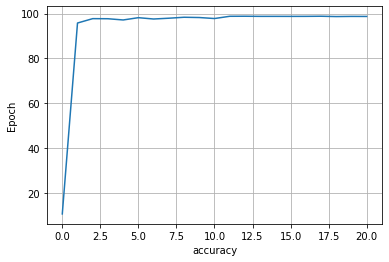

In [9]:
plt.plot(accuracy)
plt.grid()
plt.xlabel('accuracy')
plt.ylabel('Epoch')

# Learning Curve

Text(0, 0.5, 'negative log likelihood loss')

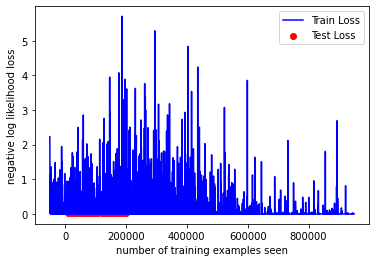

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# Accuracy on Test Set

In [ ]:
test(test_loader)


Test set: Avg. loss: 0.0180, Accuracy: 9868/10000 (99%)



In the learning curve the loss is near to zero and 1 which means it may be overfitting the data but after finding the acccuracy on test set it is cleared that model is perfectly fitted on data. 

In [ ]:
torch.set_printoptions(sci_mode=False)

# Confusion Matrix

Text(0.5, 69.0, 'Predicted label')

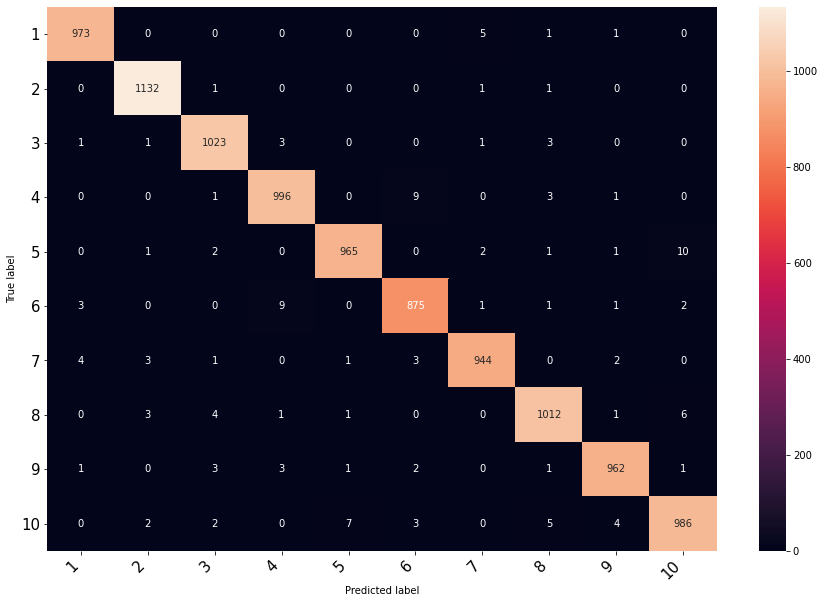

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
nb_classes = 10
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(range(1,11))
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# For ADAM Optimizer

In [10]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #learning rate scheduler that adjust the learning rate by 10% every 10 epochs

In [11]:
train_losses = []
train_counter = []
accuracy = []
test_losses = []
test_counter = [i*len(test_loader.dataset) for i in range(num_epochs + 1)]

In [13]:
num_epochs = 3
# Train Network
accuracy.append((test(valid_loader)))
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(),max_norm=1)

        # gradient descent or adam step
        optimizer.step()
        

        if batch_idx % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append((batch_idx*10) + ((epoch-1)*len(train_loader.dataset)))

    scheduler.step()
    accuracy.append(test(valid_loader))


Test set: Avg. loss: 0.2306, Accuracy: 1001/10000 (10%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.329474
Train Epoch: 0 [100/50000 (0%)]	Loss: 2.310350
Train Epoch: 0 [200/50000 (0%)]	Loss: 1.893314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train Epoch: 0 [300/50000 (1%)]	Loss: 1.796467
Train Epoch: 0 [400/50000 (1%)]	Loss: 1.254255
Train Epoch: 0 [500/50000 (1%)]	Loss: 2.757335
Train Epoch: 0 [600/50000 (1%)]	Loss: 1.569063
Train Epoch: 0 [700/50000 (1%)]	Loss: 1.547254
Train Epoch: 0 [800/50000 (2%)]	Loss: 0.477798
Train Epoch: 0 [900/50000 (2%)]	Loss: 1.239970
Train Epoch: 0 [1000/50000 (2%)]	Loss: 1.120432
Train Epoch: 0 [1100/50000 (2%)]	Loss: 1.690316
Train Epoch: 0 [1200/50000 (2%)]	Loss: 2.012102
Train Epoch: 0 [1300/50000 (3%)]	Loss: 1.100252
Train Epoch: 0 [1400/50000 (3%)]	Loss: 1.628892
Train Epoch: 0 [1500/50000 (3%)]	Loss: 1.306800
Train Epoch: 0 [1600/50000 (3%)]	Loss: 2.987272
Train Epoch: 0 [1700/50000 (3%)]	Loss: 1.410161
Train Epoch: 0 [1800/50000 (4%)]	Loss: 1.343583
Train Epoch: 0 [1900/50000 (4%)]	Loss: 1.041497
Train Epoch: 0 [2000/50000 (4%)]	Loss: 3.623581
Train Epoch: 0 [2100/50000 (4%)]	Loss: 1.156972
Train Epoch: 0 [2200/50000 (4%)]	Loss: 1.143328
Train Epoch: 0 [2300/50000 (5%)]	Loss: 1.182598

# Accuracy Graph

Text(0.5, 0, 'Epoch')

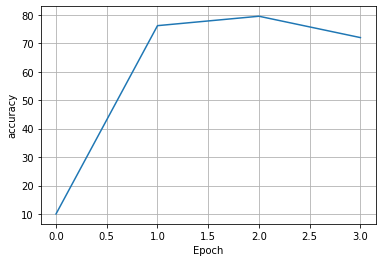

In [14]:
plt.plot(accuracy)
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('Epoch')

Text(0, 0.5, 'negative log likelihood loss')

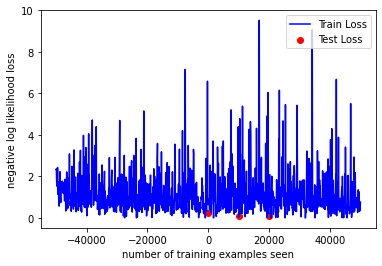

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
test(test_loader)


Test set: Avg. loss: 0.0781, Accuracy: 8239/10000 (82%)



adam optimizer is not producting the good results because of high value of learning rate also after some epochs it optimizer cant find the global minima and it stucks in one place. 

Text(0.5, 69.0, 'Predicted label')

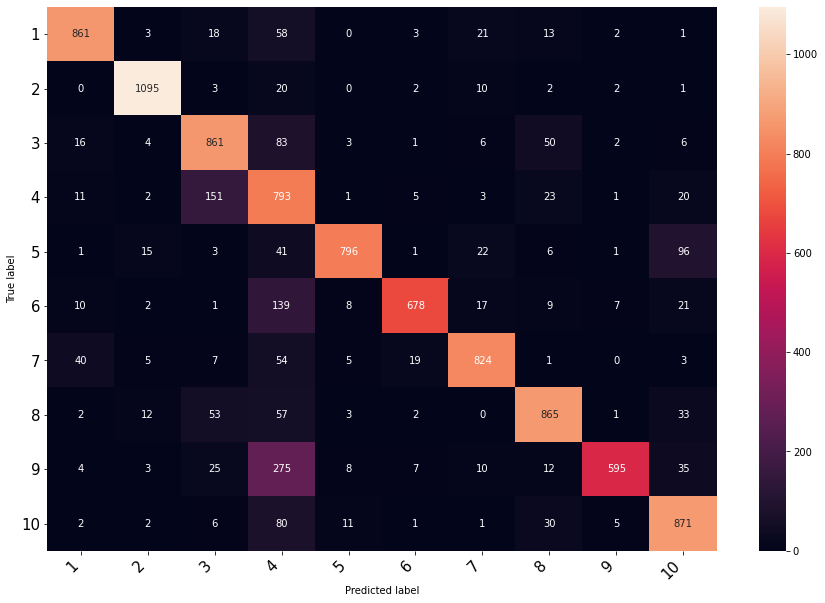

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
nb_classes = 10
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(range(1,11))
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# For Nesterov Optimizer

In [15]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,nesterov=True,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #learning rate scheduler that adjust the learning rate by 10% every 10 epochs

In [16]:
train_losses = []
train_counter = []
test_losses = []
accuracy = []
test_counter = [i*len(test_loader.dataset) for i in range(num_epochs + 1)]

In [17]:
# Train Network
accuracy.append(test(valid_loader))
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(),max_norm=1)

        # gradient descent or adam step
        optimizer.step()
        

        if batch_idx % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append((batch_idx*10) + ((epoch-1)*len(train_loader.dataset)))

    # scheduler.step()
    accuracy.append(test(valid_loader))
    if epoch%10==0:
        for g in optimizer.param_groups:
          g['lr'] = g['lr']*0.1
          print('Current Learning Rate:',g['lr'])


Test set: Avg. loss: 0.2377, Accuracy: 851/10000 (9%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.318376
Train Epoch: 0 [100/50000 (0%)]	Loss: 2.327206
Train Epoch: 0 [200/50000 (0%)]	Loss: 2.109780


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()


Train Epoch: 0 [300/50000 (1%)]	Loss: 1.570248
Train Epoch: 0 [400/50000 (1%)]	Loss: 1.151859
Train Epoch: 0 [500/50000 (1%)]	Loss: 1.018185
Train Epoch: 0 [600/50000 (1%)]	Loss: 0.326214
Train Epoch: 0 [700/50000 (1%)]	Loss: 0.453618
Train Epoch: 0 [800/50000 (2%)]	Loss: 0.249015
Train Epoch: 0 [900/50000 (2%)]	Loss: 0.538156
Train Epoch: 0 [1000/50000 (2%)]	Loss: 0.591616
Train Epoch: 0 [1100/50000 (2%)]	Loss: 0.459911
Train Epoch: 0 [1200/50000 (2%)]	Loss: 1.869588
Train Epoch: 0 [1300/50000 (3%)]	Loss: 0.402501
Train Epoch: 0 [1400/50000 (3%)]	Loss: 0.472376
Train Epoch: 0 [1500/50000 (3%)]	Loss: 0.807316
Train Epoch: 0 [1600/50000 (3%)]	Loss: 0.369375
Train Epoch: 0 [1700/50000 (3%)]	Loss: 0.107901
Train Epoch: 0 [1800/50000 (4%)]	Loss: 0.377953
Train Epoch: 0 [1900/50000 (4%)]	Loss: 0.940844
Train Epoch: 0 [2000/50000 (4%)]	Loss: 0.055543
Train Epoch: 0 [2100/50000 (4%)]	Loss: 0.339793
Train Epoch: 0 [2200/50000 (4%)]	Loss: 0.768383
Train Epoch: 0 [2300/50000 (5%)]	Loss: 0.331254

# Accuracy Graph

Text(0.5, 0, 'Epoch')

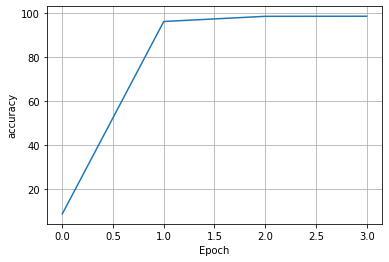

In [18]:
plt.plot(accuracy)
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('Epoch')

Text(0, 0.5, 'negative log likelihood loss')

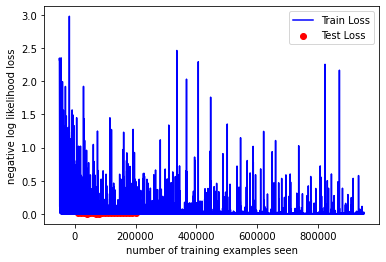

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
test(test_loader)


Test set: Avg. loss: 0.0048, Accuracy: 9897/10000 (99%)



Text(0.5, 69.0, 'Predicted label')

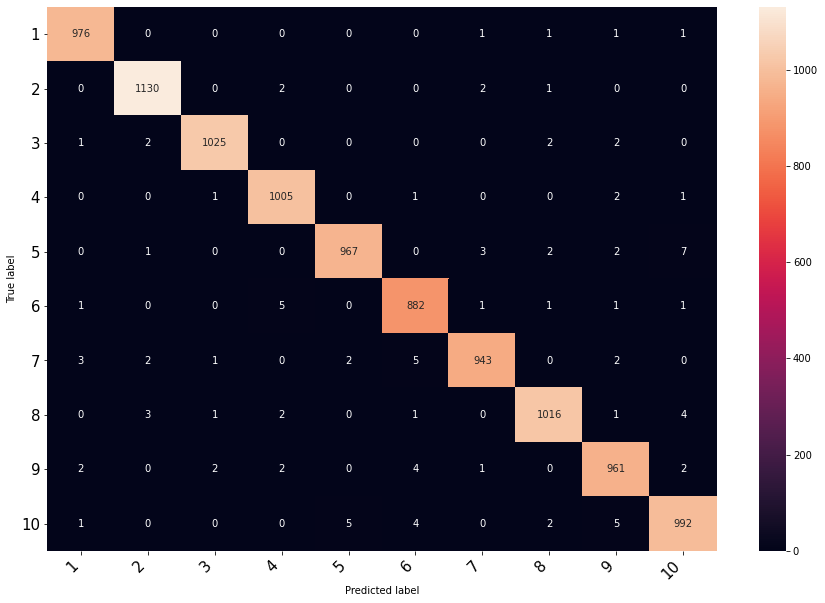

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
nb_classes = 10
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(range(1,11))
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')